# Classification of Alzhaimer through Brain MRI

## Importing Libraries

In [2]:
#Package imports.
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import tensorflow as tf
import time
from keras.utils import to_categorical
from keras import layers,models,losses
from sklearn import model_selection, metrics, preprocessing
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
#Import and mount Google Drive.
from google.colab import drive
#
drive.mount("/content/drive")

Mounted at /content/drive


## Load Images

In [4]:
#Unzip the dataset file and store it in a folder called images.
#!unzip "/content/drive/MyDrive/MRI.zip" -d "/content/drive/MyDrive/images_MRI/"

In [5]:
!ls "/content/drive/MyDrive/images_MRI/Data"

'Mild Dementia'  'Moderate Dementia'  'Non Demented'  'Very mild Dementia'


In [6]:
#Read the images and get the data in a RGB and specific shape
folder_path = "/content/drive/MyDrive/images_MRI/Data/"
size = 128
data = []
labels = []
paths=[]
count=0
for folder in os.listdir(folder_path):
    count=0
    for files in os.listdir(os.path.join(folder_path, folder)):
        if files.endswith("jpg") and count<=487:
            count+=1
            labels.append(folder)
            #Create the image path.
            img_path = os.path.join(folder_path, folder, files)
            #Read in the images.
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            #Change BGR colour default from cv2 to RGB used in matplotlib.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #Resize the images.
            img = cv2.resize(img, (size, size))
            data.append(img)
            paths.append(img_path)


#Convert the data from a list to a NumPy array.
data_arr = np.array(data)

## Select by random sampling

In [7]:
#labels_np=np.array(labels)
#selected_indices={}
#classes=['Mild Dementia','Non Demented','Very mild Dementia','Moderate Dementia']
#samples=[600,2000,600,488]
#for n,t in zip(samples,classes):
#  selected_indices[t]=np.random.choice(np.where(labels_np==t)[0],n,replace=False)
#all_indices=np.hstack((selected_indices['Mild Dementia'],selected_indices['Non Demented'],selected_indices['Very mild Dementia'],selected_indices['Moderate Dementia']))
#paths_to_delete=np.setdiff1d(np.array(paths),np.array(paths)[all_indices])
#for n in paths_to_delete:
#  os.remove(n)

## Data Analysis

In [8]:
#Check the size of the images
data_arr.shape

(1952, 128, 128, 3)

In [9]:
#Check all the classes
set(labels)

{'Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia'}

In [10]:
#Checking number of images from Mild Dementia
print('Mild Dementia:',labels.count("Mild Dementia"))
#Checking number of images from Moderate Dementia
print('Moderate Dementia:',labels.count("Moderate Dementia"))
#Checking number of images from Non Demented
print('Non Demented:',labels.count("Non Demented"))
#Checking number of images from Very mild Dementia
print('Very mild Dementia:',labels.count("Very mild Dementia"))

Mild Dementia: 488
Moderate Dementia: 488
Non Demented: 488
Very mild Dementia: 488


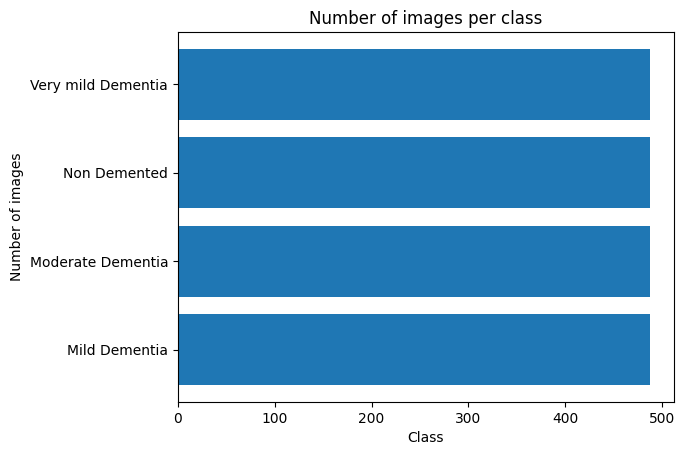

In [11]:
#Plotting horizontal barchart of the classes and images.
labels_plt=['Mild Dementia','Moderate Dementia','Non Demented','Very mild Dementia']
count=[labels.count('Mild Dementia'),labels.count('Moderate Dementia'),labels.count('Non Demented'),labels.count('Very mild Dementia')]
fig,ax=plt.subplots()
ax.barh(labels_plt,count)
ax.set_title('Number of images per class')
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
plt.show()

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

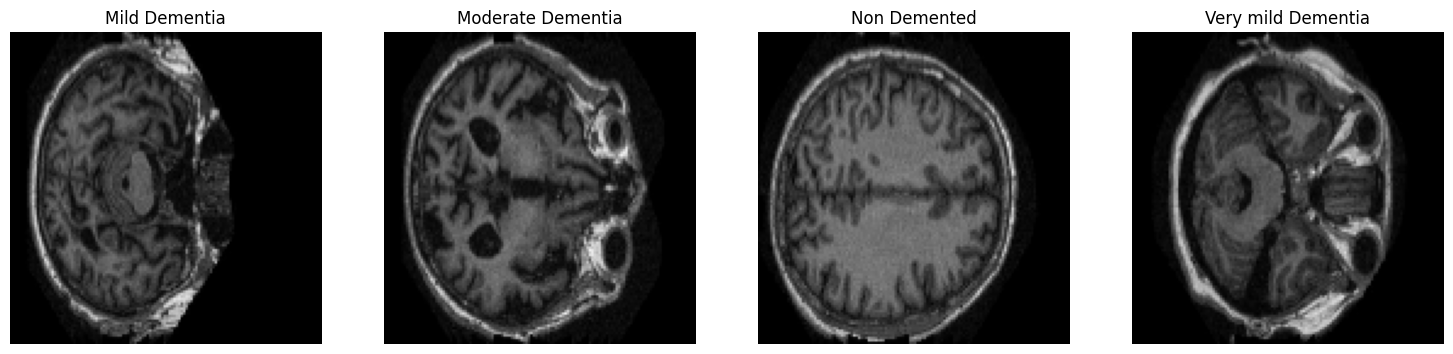

In [12]:

#Plot of examples by class of image
fig,ax=plt.subplots(1,4)
fig.set_size_inches(18.5, 10.5)
ax[0].imshow(data_arr[np.random.choice(range(1,450),1)[0]])
ax[0].set_title('Mild Dementia')
ax[0].axis('off')
ax[1].imshow(data_arr[np.random.choice(range(451,900),1)[0]])
ax[1].set_title('Moderate Dementia')
ax[1].axis('off')
ax[2].imshow(data_arr[np.random.choice(range(901,1350),1)[0]])
ax[2].set_title('Non Demented')
ax[2].axis('off')
ax[3].imshow(data_arr[np.random.choice(range(1351,1800),1)[0]])
ax[3].set_title('Very mild Dementia')
ax[3].axis('off')

## Preprocessing

### Create noise and data augmentation

In [13]:
#Function for create noise in the image.
def image_noise(image, noise_level):
    image = tf.cast(image, tf.int32)
    height, width, channels = image.shape[0], image.shape[1], image.shape[2]
    pixels_total = height * width * channels
    noise_added = pixels_total * noise_level
    noise_total=0
    #Get the percentage of noise
    while noise_total<noise_added:
      w=random.randint(1,3)
      h=random.randint(1,3)
      x=random.randint(1,width-w)
      y=random.randint(1,height-h)
      noise_total += w*h
      noise_to_add=w*h*3
      #Create the indices for introduce noise
      indices = [[j, k, i] for i in range(3) for j
                 in range(y, y + h) for k in range(x, x + w)]
      #Generate black noise
      noise_values = [np.random.randint(1,25)]*noise_to_add
      #Introduce noise
      image = tf.tensor_scatter_nd_update(image, indices, noise_values)
    return image

In [14]:
#Function for augment the images
def image_augment(image,seed):
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]#
    #Random left flip
    #image = tf.image.stateless_random_flip_left_right(
    #   image, seed)#
    #Random brightness change
    #image = tf.image.stateless_random_brightness(
    #    image, max_delta=0.1, seed=new_seed)
    #Introduce hue
    #image = tf.image.stateless_random_hue(
    #    image, 0.2, seed)
    #Introduce saturation
    image = tf.image.stateless_random_saturation(
        image, 0.3, 1.0, seed)
    #Adjust any value to the RGB range
    #image = tf.clip_by_value(image, 0, 255)
    return image

In [15]:
#Set the random seed generator
rng = tf.random.Generator.from_seed(123, alg='philox')

In [16]:
#Function to prepare the images with noise and augmentation
def image_wrapper(image):
  #Generate random independent seed
  seed=rng.make_seeds(2)[0]
  #Augment data with the random seed
  image1=image_augment(image,seed)
  #Add noise
  image2=image_noise(image1,0.1)
  return image2/255,image1/255

In [17]:
#Function to prepare the images augmentation
def image_label_wrapper(image,label):
  #Generate random independent seed
  seed=rng.make_seeds(2)[0]
  #Augment data with the random seed
  image1=image_augment(image,seed)
  return image1/255,label

In [18]:
#Get dataset tensorflow type
data=tf.data.Dataset.from_tensor_slices(data_arr)

In [19]:
label_encoder=preprocessing.LabelEncoder()
label_encoder.fit(labels)
labels_encoded=label_encoder.transform(labels)
labels_encoded=to_categorical(labels_encoded)

In [20]:
#Split train and test
data_train,data_test,label_train,label_test=model_selection.train_test_split(data_arr,labels_encoded, test_size=0.1, random_state=42,stratify=labels_encoded)
data_train,data_validation,label_train,label_validation=model_selection.train_test_split(data_train,label_train, test_size=0.2, random_state=42,stratify=label_train)

In [21]:
#Preprocess the data for denoising
data_train_processed=tf.data.Dataset.from_tensor_slices(data_train).shuffle(100).map(image_wrapper).batch(32)

In [22]:
data_validation_noise=np.array([image_noise(x,0.1) for x in data_validation])
data_validation_processed=tf.data.Dataset.from_tensor_slices((data_validation_noise/255,data_validation/255)).batch(32)

data_test_noise=np.array([image_noise(x,0.1) for x in data_test])
data_test_processed=tf.data.Dataset.from_tensor_slices((data_test_noise/255,data_test/255)).batch(32)

In [23]:
data_train_classification_processed=tf.data.Dataset.from_tensor_slices((data_train,label_train)).shuffle(100).map(image_label_wrapper).batch(32)
data_validation_classification_processed=tf.data.Dataset.from_tensor_slices((data_validation/255,label_validation)).batch(32)
data_test_classification_processed=tf.data.Dataset.from_tensor_slices((data_test/255,label_test)).batch(32)

In [24]:
#Get data preprocessed
data_test_processed

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None))>

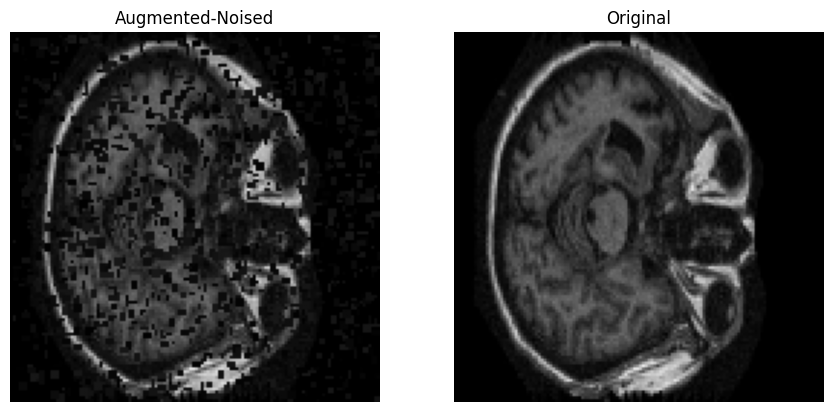

In [25]:
#Examples of
for item in data_train_processed.take(1):
    fig,ax=plt.subplots(1,2)
    fig.set_size_inches(10.5, 7.5)
    ax[0].imshow(item[0][0].numpy())
    ax[0].set_title('Augmented-Noised')
    ax[0].axis('off')
    ax[1].imshow(item[1][0].numpy())
    ax[1].set_title('Original')
    ax[1].axis('off')

In [26]:
test_original = np.asarray(list(data_test_processed.unbatch().map(lambda x, y: y)))

## Denoising

In [27]:
single_test_original=np.expand_dims(data_arr[1]/255,axis=0)
single_test_noise=np.expand_dims(image_noise(data_arr[1],0.07).numpy()/255,axis=0)

### Denoising measures

In [28]:
#Mean squared error between 2 images
def mse(image1,image2):
  mse=np.mean((image1.astype('float')-image2.astype('float'))**2)
  return mse

In [29]:
#Mean squared error between 2 groups of images
def mse_mean(image1,image2):
  mse_values=[]
  for n in range(0,image1.shape[0]):
      mse_value = mse(image1[n],image2[n])
      mse_values.append(mse_value)

  mse_mean = np.mean(mse_values)
  return mse_mean

In [30]:
#Peak signal to noise ratio between two groups of images
def psnr_mean(image1,image2):
  psnr_values=[]
  for n in range(0,image1.shape[0]):
    mse1=mse(image1[n],image2[n])
    psnr=20*np.log10(1/np.sqrt(mse1))
    psnr_values.append(psnr)
  psnr_mean = np.mean(psnr_values)
  return psnr_mean

In [31]:
#Structural similarity index between two images
def ssim_mean(image1,image2):
  ssim_values=[]
  for n in range(0,image1.shape[0]):
      ssim_value = ssim(image1[n],image2[n],channel_axis=2,data_range=image1[n].max()-image1[n].min())
      ssim_values.append(ssim_value)
  ssim_mean = np.mean(ssim_values)
  return ssim_mean

### Autoencoder

#### Model Architecture

In [32]:
#Basic auto encoder for denoising
#Encoder 1Conv + BatchNorm + MaxPooling
def encoder(filters):
    def apply(x):
        x=layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.MaxPooling2D((2,2),padding='same')(x)
        return x
    return apply

In [33]:
#Decoder 1ConvTrans + BatchNorm
def decoder(filters):
    def apply(x):
        x=layers.Conv2DTranspose(filters, (3,3), strides=2, padding='same', activation='relu')(x)
        x=layers.BatchNormalization()(x)
        return x
    return apply

In [34]:
#Auto Encoder 3Encoder + 3Decoder from 3 to 128
def autoencoder(input_shape=(128, 128, 3)):
    inputs=layers.Input(shape=input_shape)
    #Encoder
    x=encoder(32)(inputs)
    x=encoder(64)(x)
    x=encoder(128)(x)
    #Decoder
    x=decoder(128)(x)
    x=decoder(64)(x)
    x=decoder(32)(x)
    outputs=layers.Conv2D(3, (1,1), activation='sigmoid')(x)
    return models.Model(inputs, outputs)

In [36]:
#Define autoencoder and see the structure
ae=autoencoder()
ae.save_weights('ae_initial_model_weights.weights.h5')
ae.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 3)         │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 334,979 (1.28 MB)

 Trainable params: 334,083 (1.27 MB)

 Non-trainable params: 896 (3.50 KB)

In [37]:
#Compile model with adam and mean squared error
ae.compile(optimizer='adam',loss='mse')

#### Model Train and Test

In [ ]:
ae_history=ae.fit(data_train_processed,epochs=10,validation_data=data_validation_processed)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 580ms/step - loss: 0.1187 - val_loss: 0.0766
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - loss: 0.0514 - val_loss: 0.0374
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - loss: 0.0304 - val_loss: 0.0296
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 380ms/step - loss: 0.0192 - val_loss: 0.0307
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - loss: 0.0124 - val_loss: 0.0309
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 388ms/step - loss: 0.0087 - val_loss: 0.0280
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - loss: 0.0067 - val_loss: 0.0245
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 390ms/step - loss: 0.0055 - val_loss: 0.0205
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - loss: 0.0047 - val_loss: 0.0160
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - loss: 0.0042 - val_loss: 0.0130


In [ ]:
ae_prediction=ae.predict(single_test_noise)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(-0.5, 127.5, 127.5, -0.5)

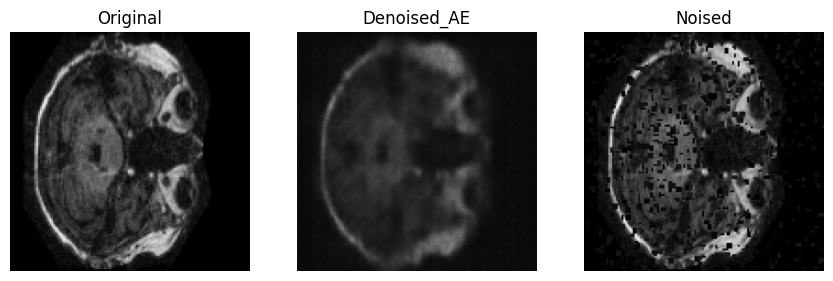

In [ ]:

fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
#fig.suptitle('Auto Encoder denoising',fontsize=16)
ax[0].imshow(single_test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(ae_prediction[0])
ax[1].set_title('Denoised_AE')
ax[1].axis('off')
ax[2].imshow(single_test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

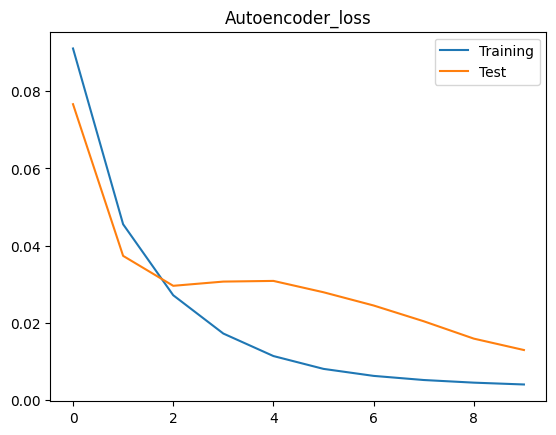

In [ ]:
plt.plot(ae_history.history['loss'],label='Training')
plt.plot(ae_history.history['val_loss'],label='Test')
plt.title('Autoencoder_loss')
plt.legend()
plt.show()

In [ ]:
ae_predicted=ae.predict(data_test_processed)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step


In [ ]:
ae_mse=mse_mean(test_original,ae_predicted)
ae_psnr=psnr_mean(test_original,ae_predicted)
ae_ssim=ssim_mean(test_original,ae_predicted)
print('MSE:',round(ae_mse,3))
print('PSNR:',round(ae_psnr,3))
print('SSIM:',round(ae_ssim,3))

MSE: 0.013
PSNR: 67.159
SSIM: 0.349


#### Model Train and Test with Hyperparameters

In [38]:
learning_rates=[1e-3,1e-4,1e-5]

In [39]:
loss=[]
for l in learning_rates:
  ae.load_weights('ae_initial_model_weights.weights.h5')
  ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l),loss='mse')
  ae_history=ae.fit(data_train_processed,epochs=40,validation_data=data_validation_processed)
  loss.append(ae_history.history['loss'])

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 533ms/step - loss: 0.1211 - val_loss: 0.0754
Epoch 2/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 372ms/step - loss: 0.0500 - val_loss: 0.0364
Epoch 3/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 387ms/step - loss: 0.0291 - val_loss: 0.0297
Epoch 4/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - loss: 0.0184 - val_loss: 0.0307
Epoch 5/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - loss: 0.0120 - val_loss: 0.0311
Epoch 6/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 398ms/step - loss: 0.0082 - val_loss: 0.0294
Epoch 7/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - loss: 0.0060 - val_loss: 0.0252
Epoch 8/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 378ms/step - loss: 0.0049 - val_loss: 0.0201
Epoch 9/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 374ms/step - loss: 0.0042 - val_loss: 0.0162
Epoch 10/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 374ms/step - loss: 0.0038 - val_loss: 0.0113
Epoch 11/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 385ms/step - loss: 0.0034 - val_loss: 0.0084
Epoch 12/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 54 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 427ms/step - loss: 0.1666 - val_loss: 0.1285
Epoch 2/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 378ms/step - loss: 0.1132 - val_loss: 0.1056
Epoch 3/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - loss: 0.0953 - val_loss: 0.0863
Epoch 4/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 386ms/step - loss: 0.0850 - val_loss: 0.0719
Epoch 5/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - loss: 0.0760 - val_loss: 0.0623
Epoch 6/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 364ms/step - loss: 0.0685 - val_loss: 0.0744
Epoch 7/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 387ms/step - loss: 0.0639 - val_loss: 0.0713
Epoch 8/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - loss: 0.0607 - val_loss: 0.0656
Epoch 9/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 383ms/step - loss: 0.0577 - val_loss: 0.0603
Epoch 10/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - loss: 0.0553 - val_loss: 0.0552
Epoch 11/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 379ms/step - loss: 0.0528 - val_loss: 0.0506
Epoch 12/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/ste

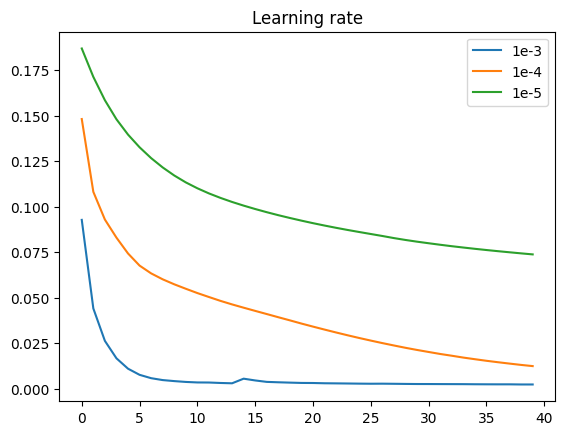

In [41]:
plt.plot(loss[0],label='1e-3')
plt.plot(loss[1],label='1e-4')
plt.plot(loss[2],label='1e-5')
plt.title('Learning rate')
plt.legend()
plt.show()

### U-Net

In [32]:
#U-Net for denoising images
#DoubleConv 1Conv + 1BatchNorm + 1Conv + 1BatchNorm
def unet_double_conv(filters):
    def apply(x):
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        return x
    return apply

In [33]:
#U-Net encoder 1MaxPooling + 1DoubleConv
def unet_encoder(filters):
    def apply(x):
        x=layers.MaxPooling2D((2,2))(x)
        x=unet_double_conv(filters)(x)
        return x
    return apply

In [34]:
#U-Net decoder 1ConvTrans + 1Concatenate +1DoubleConv
def unet_decoder(filters):
    def apply(x, skip):
        x=layers.Conv2DTranspose(filters,(3,3),activation='relu',strides=2,padding='same')(x)
        x=layers.Concatenate()([x, skip])
        x=unet_double_conv(filters)(x)
        return x
    return apply

In [35]:
#U-Net from 3 to 1024 with MaxPooling
def unet(input_shape=(128, 128, 3)):
    input = layers.Input(shape=input_shape)
    #Encoder from 3 to 1024
    x1 = unet_double_conv(64)(input)
    x2 = unet_encoder(128)(x1)
    x3 = unet_encoder(256)(x2)
    x4 = unet_encoder(512)(x3)
    x  = unet_encoder(1024)(x4)
    #Decoder feom 512 to 3
    x = unet_decoder(512)(x, x4)
    x = unet_decoder(256)(x, x3)
    x = unet_decoder(128)(x, x2)
    x = unet_decoder(64)(x, x1)
    output = layers.Conv2D(3,(1,1),activation='sigmoid')(x)
    return models.Model(input,output)

In [36]:
unet=unet()
unet.save_weights('unet_initial_model_weights.weights.h5')
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 32, 32, 256)    │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2      

 Total params: 34,537,027 (131.75 MB)

 Trainable params: 34,525,251 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [37]:
#Compile the unet with adam and mse
unet.compile(optimizer='adam',loss='mse')

#### Model fit and train

In [37]:
#fit unet with train and validation sets
unet_history=unet.fit(data_train_processed,epochs=10,validation_data=data_validation_processed)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - loss: 0.0935 - val_loss: 0.6461
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 828ms/step - loss: 0.0230 - val_loss: 0.0405
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 841ms/step - loss: 0.0112 - val_loss: 0.0298
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 833ms/step - loss: 0.0063 - val_loss: 0.0304
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 828ms/step - loss: 0.0041 - val_loss: 0.0291
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 835ms/step - loss: 0.0029 - val_loss: 0.0267
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 824ms/step - loss: 0.0024 - val_loss: 0.0250
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 821ms/step - loss: 0.0018 - val_loss: 0.0211
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 829ms/step - loss: 0.0015 - val_loss: 0.0176
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 829ms/step - loss: 0.0013 - val_loss: 0.0136


In [38]:
#Predict a single test
unet_predicted=unet.predict(single_test_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

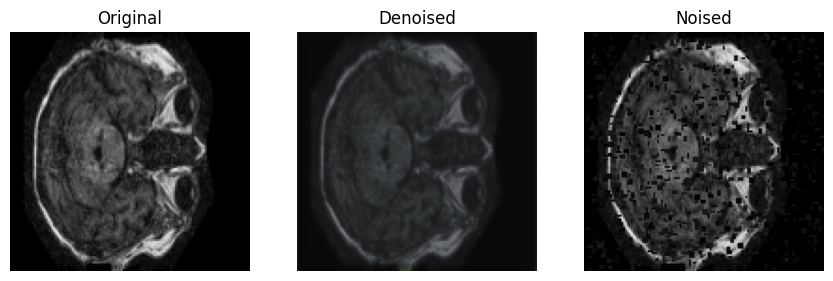

In [39]:
#Check the first results of the model
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(single_test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(unet_predicted[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(single_test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

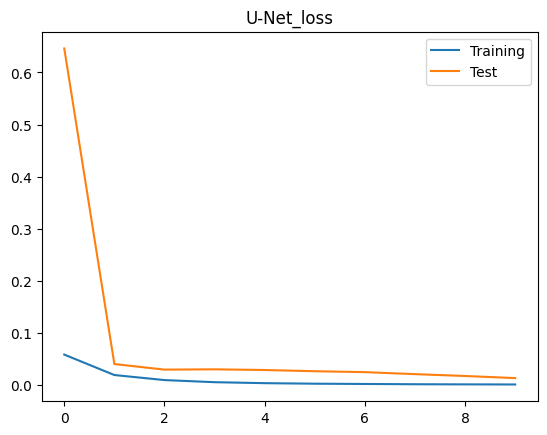

In [40]:
plt.plot(unet_history.history['loss'],label='Training')
plt.plot(unet_history.history['val_loss'],label='Test')
plt.title('U-Net_loss')
plt.legend()
plt.show()

In [41]:
unet_predicted=unet.predict(data_test_processed)

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


In [42]:
unet_mse=mse_mean(test_original,unet_predicted)
unet_psnr=psnr_mean(test_original,unet_predicted)
unet_ssim=ssim_mean(test_original,unet_predicted)
print('MSE:',round(unet_mse,3))
print('PSNR:',round(unet_psnr,3))
print('SSIM:',round(unet_ssim,3))

MSE: 0.014
PSNR: 18.752
SSIM: 0.428


#### Model Train and Test with Hyperparameters

In [38]:
learning_rates=[1e-3,1e-4,1e-5]

In [39]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,verbose=1,restore_best_weights=True)

In [ ]:
loss_unet=[]
time_unet=[]
for n,l in enumerate(learning_rates):
  start_time=time.time()
  checkpoint=ModelCheckpoint('unet_weights_{l}.keras'.format(l=n), monitor='val_loss', save_best_only=True, verbose=1)
  unet.load_weights('unet_initial_model_weights.weights.h5')
  unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l),loss='mse')
  unet_history=unet.fit(data_train_processed,epochs=10,validation_data=data_validation_processed,callbacks=[reduce_lr,checkpoint])
  loss_unet.append(unet_history.history['val_loss'])
  total_time=time.time()-start_time
  time_unet.append(total_time)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/44 ━━━━━━━━━━━━━━━━━━━━ 31:02 64s/step - loss: 0.1388

In [ ]:
plt.plot(loss_unet[0],label='1e-3')
plt.plot(loss_unet[1],label='1e-4')
plt.plot(loss_unet[2],label='1e-5')
plt.title('U-Net Loss | Learning rate')
plt.legend()
plt.show()

In [ ]:
for l in learning_rates:
  unet.load_weights('unet_weights_{l}.keras'.format(l=learning_rates.index(l)))
  unet_predicted=unet.predict(data_test_processed)
  unet_mse=mse_mean(test_original,unet_predicted)
  unet_psnr=psnr_mean(test_original,unet_predicted)
  unet_ssim=ssim_mean(test_original,unet_predicted)
  print('Learning rate:',l)
  print('MSE:',round(unet_mse,3))
  print('PSNR:',round(unet_psnr,3))
  print('SSIM:',round(unet_ssim,3))
  print('Learning rate:',l)
  print('Time:',round(time_unet[learning_rates.index(l)],2))

### U-Net Residual (Upsampling)

In [ ]:
def unet_conv_res(filters):
    def apply(x):
        conv = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        conv = layers.BatchNormalization()(conv)
        conv = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(conv)
        conv = layers.BatchNormalization()(conv)

        shortcut=layers.Conv2D(filters, (1,1), padding='same', activation='relu')(x)
        shortcut = layers.BatchNormalization()(shortcut)

        res = layers.Add()([shortcut, conv])
        res = layers.Activation('relu')(res)
        return res
    return apply

In [ ]:
#U-Net with updampling for denoising images
#DoubleConv 1Conv + 1BatchNorm + 1Conv + 1BatchNorm
def unet2_conv(filters):
    def apply(x):
        x = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        return x
    return apply

In [ ]:
#Unet encoder with 1MaxPoolin and +1DoubleConv
def unet_encoder_res(filters):
    def apply(x):
        x = layers.MaxPooling2D((2,2))(x)
        x = unet_conv_res(filters)(x)
        return x
    return apply

In [ ]:
#Unet decoder with 1Upsampling + 1ConvTrans +1Concat + 1DoubleConv
def unet_decoder_res(filters):
    def apply(x, skip):
        x = layers.UpSampling2D((2,2))(x)
        x = layers.Conv2DTranspose(filters, (1,1), activation='relu')(x)
        x = layers.Concatenate()([x, skip])
        x = unet_conv_res(filters)(x)
        return x
    return apply

In [ ]:
#U-Net from 3 to 1024 with Upsampling
def unet_res(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)
    #Encoder from 3 to 1024
    x1 = unet_conv_res(64)(inputs)
    x2 = unet_encoder_res(128)(x1)
    x3 = unet_encoder_res(256)(x2)
    x4 = unet_encoder_res(512)(x3)
    x  = unet_encoder_res(1024)(x4)
    #Decoder from 512 to 3
    x = unet_decoder_res(512)(x, x4)
    x = unet_decoder_res(256)(x, x3)
    x = unet_decoder_res(128)(x, x2)
    x = unet_decoder_res(64)(x, x1)
    outputs = layers.Conv2D(3, (1,1), activation='sigmoid')(x)
    return models.Model(inputs, outputs)

In [ ]:
#U-Net with Upsampling model with summary
unet_res = unet_res()
unet_res.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 128, 128, 64)   │            256 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 128, 128, 64)   │            256 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_26    │ (None, 128, 128, 64)   │            256 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 128, 128, 64)   │            256 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 64)   │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 64, 64, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 64, 64, 128)    │            512 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 64, 64, 128)    │          8,320 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_29    │ (None, 64, 64, 128)    │            512 │ conv2d_28[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2

 Total params: 30,374,019 (115.87 MB)

 Trainable params: 30,356,355 (115.80 MB)

 Non-trainable params: 17,664 (69.00 KB)

In [ ]:
#U-Net with upsampling compile with adam and mse
unet_res.compile(optimizer='adam',loss='mse')

In [ ]:
unet_res_history=unet_res.fit(data_train_processed,epochs=15,validation_data=data_validation_processed)

Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 860ms/step - loss: 9.8645e-04 - val_loss: 0.0155
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 836ms/step - loss: 9.3553e-04 - val_loss: 0.0113
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 859ms/step - loss: 9.0690e-04 - val_loss: 0.0090
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 839ms/step - loss: 8.3614e-04 - val_loss: 0.0070
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 834ms/step - loss: 8.2868e-04 - val_loss: 0.0048
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 840ms/step - loss: 7.9069e-04 - val_loss: 0.0032
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 842ms/step - loss: 7.8387e-04 - val_loss: 0.0020
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 852ms/step - loss: 7.6556e-04 - val_loss: 0.0932
Epoch 9/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 861ms/step - loss: 0.0039 - val_loss: 0.0514
Epoch 10/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 839ms/step - loss: 0.0015 - val_loss: 0.0573
Epoch 11/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 843ms/step - loss: 0.0012 - val_loss: 0.0349
Epoch 12/

In [ ]:
single_unet_res_predicted=unet_res.predict(single_test_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


(-0.5, 127.5, 127.5, -0.5)

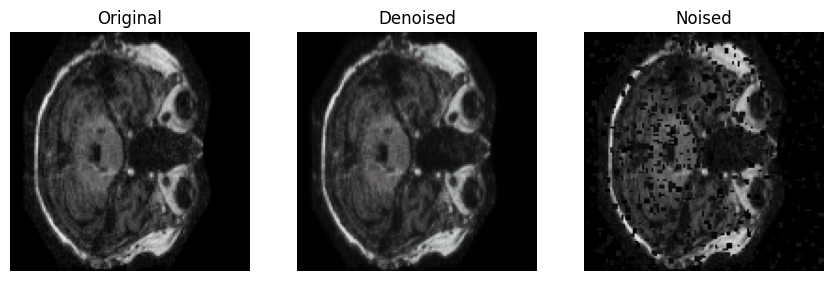

In [ ]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(single_test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(single_unet_res_predicted[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(single_test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

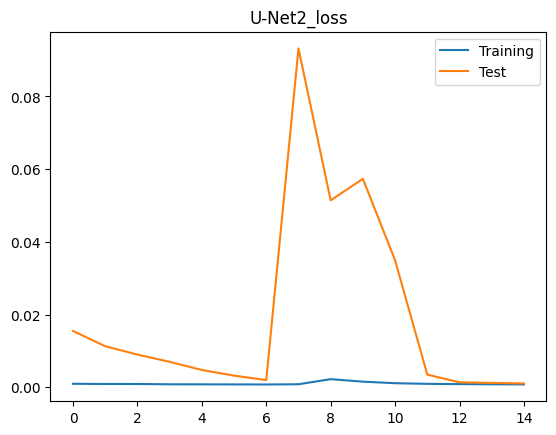

In [ ]:
plt.plot(unet_res_history.history['loss'],label='Training')
plt.plot(unet_res_history.history['val_loss'],label='Test')
plt.title('U-Net2_loss')
plt.legend()
plt.show()

In [ ]:
unet_res_predicted=unet_res.predict(data_test_processed)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step


In [ ]:
unet_res_mse=mse_mean(test_original,unet_res_predicted)
unet_res_psnr=psnr_mean(test_original,unet_res_predicted)
unet_res_ssim=ssim_mean(test_original,unet_res_predicted)
print('MSE:',round(unet_res_mse,3))
print('PSNR:',round(unet_res_psnr,3))
print('SSIM:',round(unet_res_ssim,3))

MSE: 0.001
PSNR: 29.94
SSIM: 0.903


## Classification

### Transfer learning ResNet50

In [26]:
res_model=tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(128,128,3),pooling='avg')

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [28]:
res_model.trainable=False

In [29]:
res_transfer=tf.keras.Sequential([
    res_model,
    layers.BatchNormalization(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4,activation='softmax')
])

res_transfer.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,153,860 (92.14 MB)

 Trainable params: 562,052 (2.14 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [30]:
res_transfer.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','precision','recall'])

In [31]:
res_transfer_history=res_transfer.fit(data_train_classification_processed,epochs=30,validation_data=data_validation_classification_processed)#,callbacks=[early_stop,checkpoint,reduce_lr])

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 314ms/step - accuracy: 0.4425 - loss: 1.2178 - precision: 0.6659 - recall: 0.1264 - val_accuracy: 0.2500 - val_loss: 1.5968 - val_precision: 0.2529 - val_recall: 0.2443
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.6989 - loss: 0.7844 - precision: 0.8015 - recall: 0.5391 - val_accuracy: 0.2926 - val_loss: 1.7070 - val_precision: 0.4245 - val_recall: 0.1676
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7764 - loss: 0.5642 - precision: 0.8431 - recall: 0.7034 - val_accuracy: 0.2784 - val_loss: 1.8782 - val_precision: 0.3281 - val_recall: 0.2358
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.8093 - loss: 0.5002 - precision: 0.8440 - recall: 0.7645 - val_accuracy: 0.3068 - val_loss: 1.7662 - val_precision: 0.3358 - val_recall: 0.2585
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8640 - loss: 0.3688 - precision: 0.9015 - recall: 0.8435 - val_accuracy: 0.3466 - val_loss: 1.600

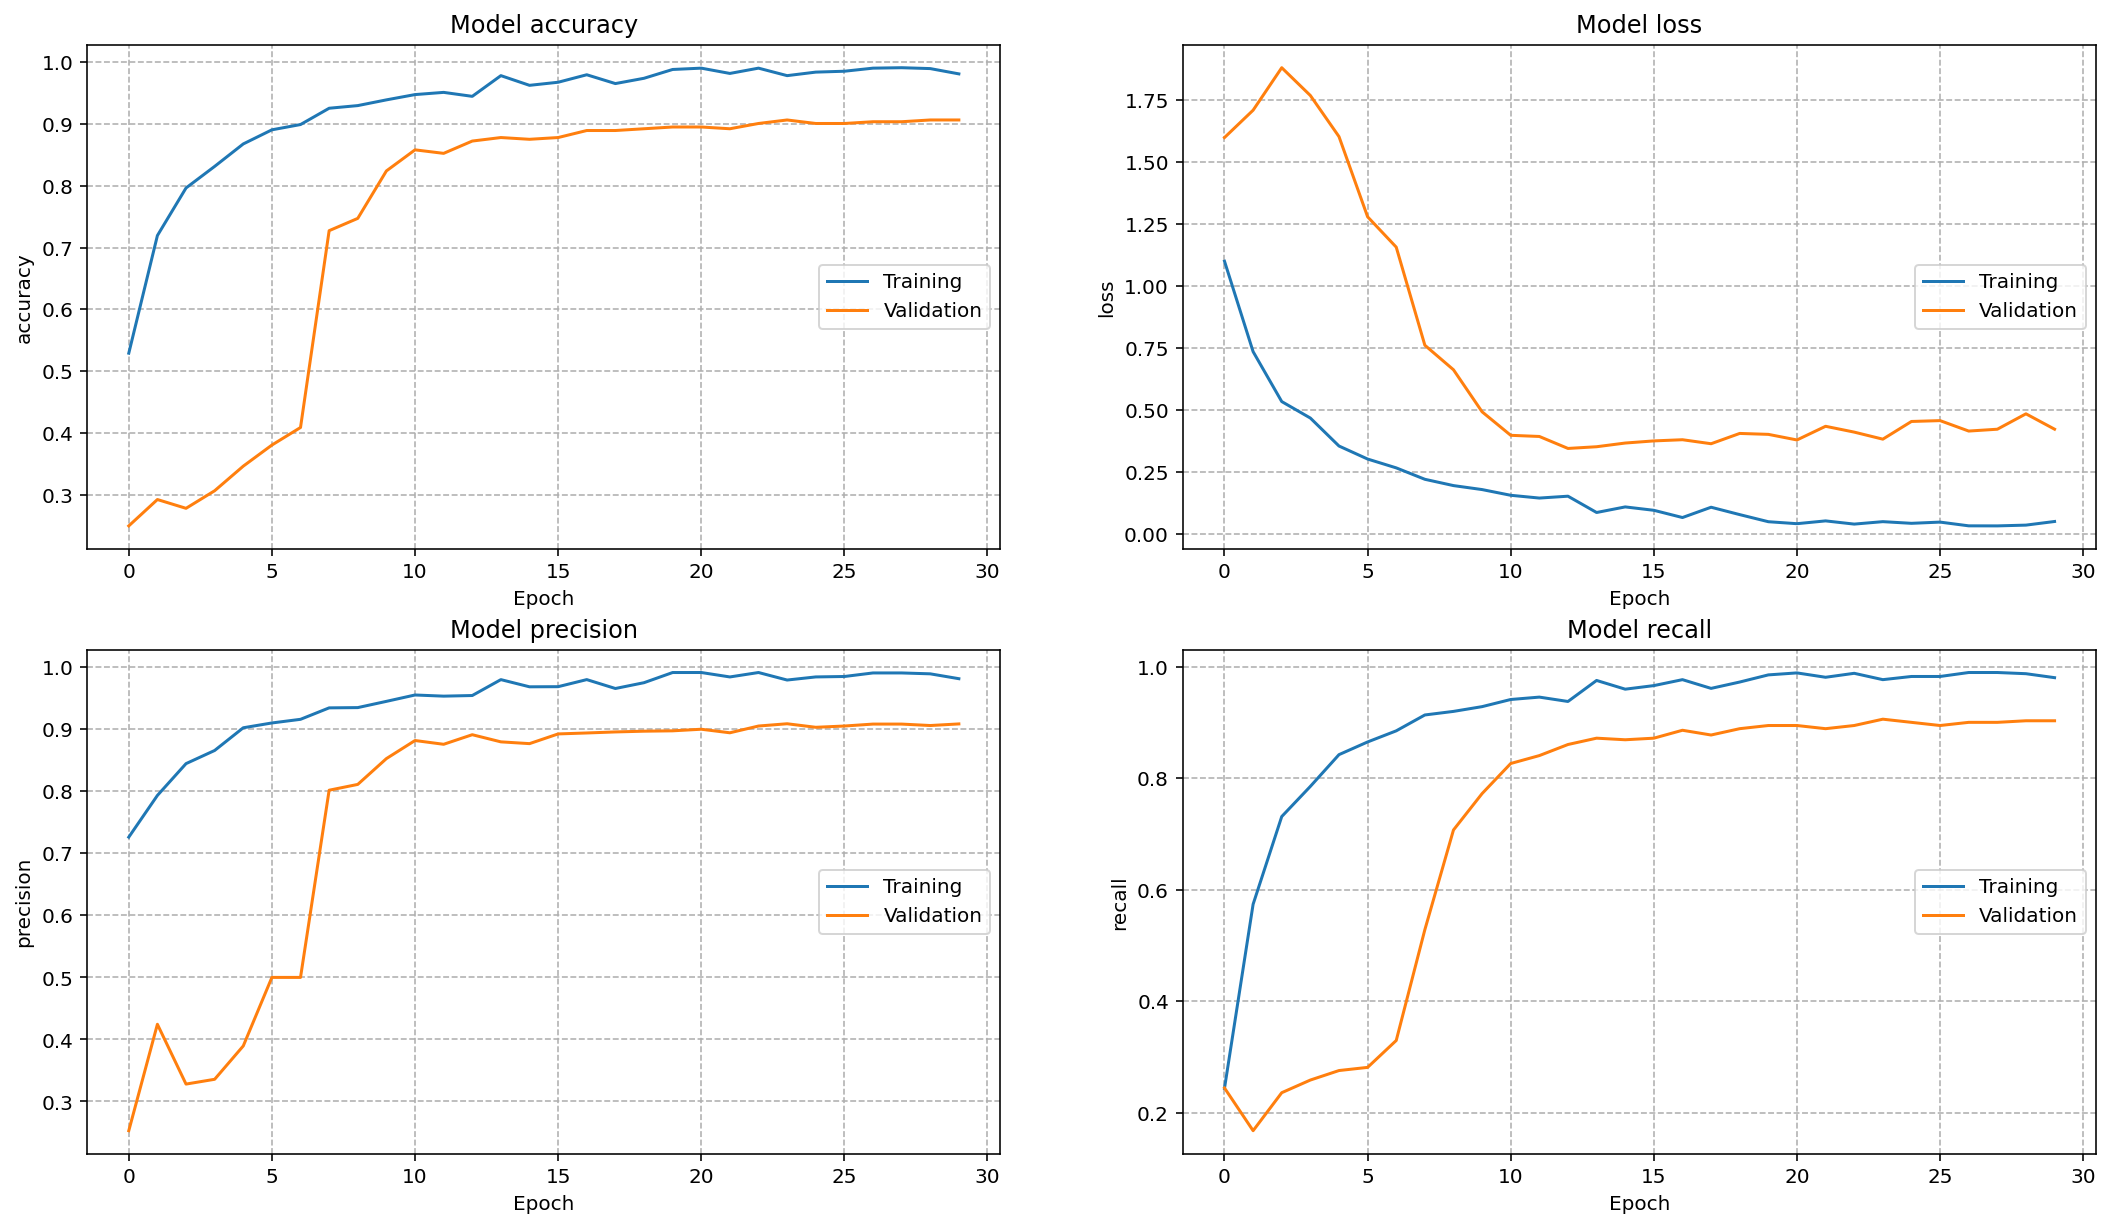

In [32]:
fig, ax = plt.subplots(2, 2, dpi=144, figsize=(18,10))
ax = ax.flatten()
for i, metric in enumerate(['accuracy', 'loss', 'precision', 'recall']):
    ax[i].plot(res_transfer_history.history[metric], label='Training')
    ax[i].plot(res_transfer_history.history[f'val_{metric}'], label='Validation')
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].legend(loc='center right')
    ax[i].grid(linestyle='--', ms=0.5)
plt.show()

In [33]:
res_predicted=res_transfer.predict(data_test/255)
res_predicted=np.argmax(res_predicted,axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 918ms/step


                    precision    recall  f1-score   support

     Mild Dementia       0.92      0.92      0.92        49
 Moderate Dementia       1.00      1.00      1.00        49
      Non Demented       0.93      0.82      0.87        49
Very mild Dementia       0.84      0.94      0.88        49

          accuracy                           0.92       196
         macro avg       0.92      0.92      0.92       196
      weighted avg       0.92      0.92      0.92       196



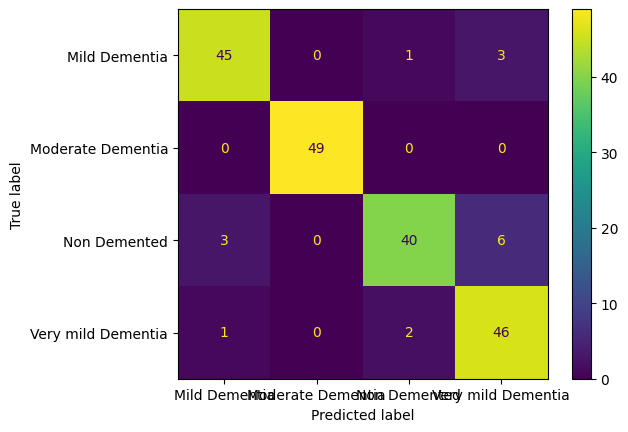

In [34]:
cm=confusion_matrix(np.argmax(label_test,axis=1),res_predicted)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_encoder.classes_)
disp.plot()

print(classification_report(np.argmax(label_test,axis=1),res_predicted,target_names=label_encoder.classes_))

### Transfer Learning EffiecientNet

In [21]:
ef_model=tf.keras.applications.EfficientNetB0(include_top=False,weights='imagenet',input_shape=(128,128,3),pooling='avg')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [22]:
ef_transfer=tf.keras.Sequential([
    ef_model,
    layers.BatchNormalization(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4,activation='softmax')
])

ef_transfer.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,416,039 (16.85 MB)

 Trainable params: 4,371,456 (16.68 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [23]:
ef_transfer.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','precision','recall'])

In [24]:
#ef_model.trainable=False

In [25]:
ef_transfer_history=ef_transfer.fit(data_train_classification_processed,epochs=30,validation_data=data_validation_classification_processed)#,callbacks=[early_stop,checkpoint,reduce_lr])

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.4470 - loss: 1.3266 - precision: 0.4962 - recall: 0.3266 - val_accuracy: 0.2500 - val_loss: 1.3975 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.7146 - loss: 0.7288 - precision: 0.7546 - recall: 0.6588 - val_accuracy: 0.2500 - val_loss: 1.4859 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.8084 - loss: 0.4862 - precision: 0.8404 - recall: 0.7849 - val_accuracy: 0.2500 - val_loss: 1.6602 - val_precision: 0.1836 - val_recall: 0.1080
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.8753 - loss: 0.3086 - precision: 0.8856 - recall: 0.8555 - val_accuracy: 0.2472 - val_loss: 1.8371 - val_precision: 0.2524 - val_recall: 0.2273
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9292 - loss: 0.2297 - precision: 0.9314 - recall: 0.9178 - val_accuracy: 0.3097 - 

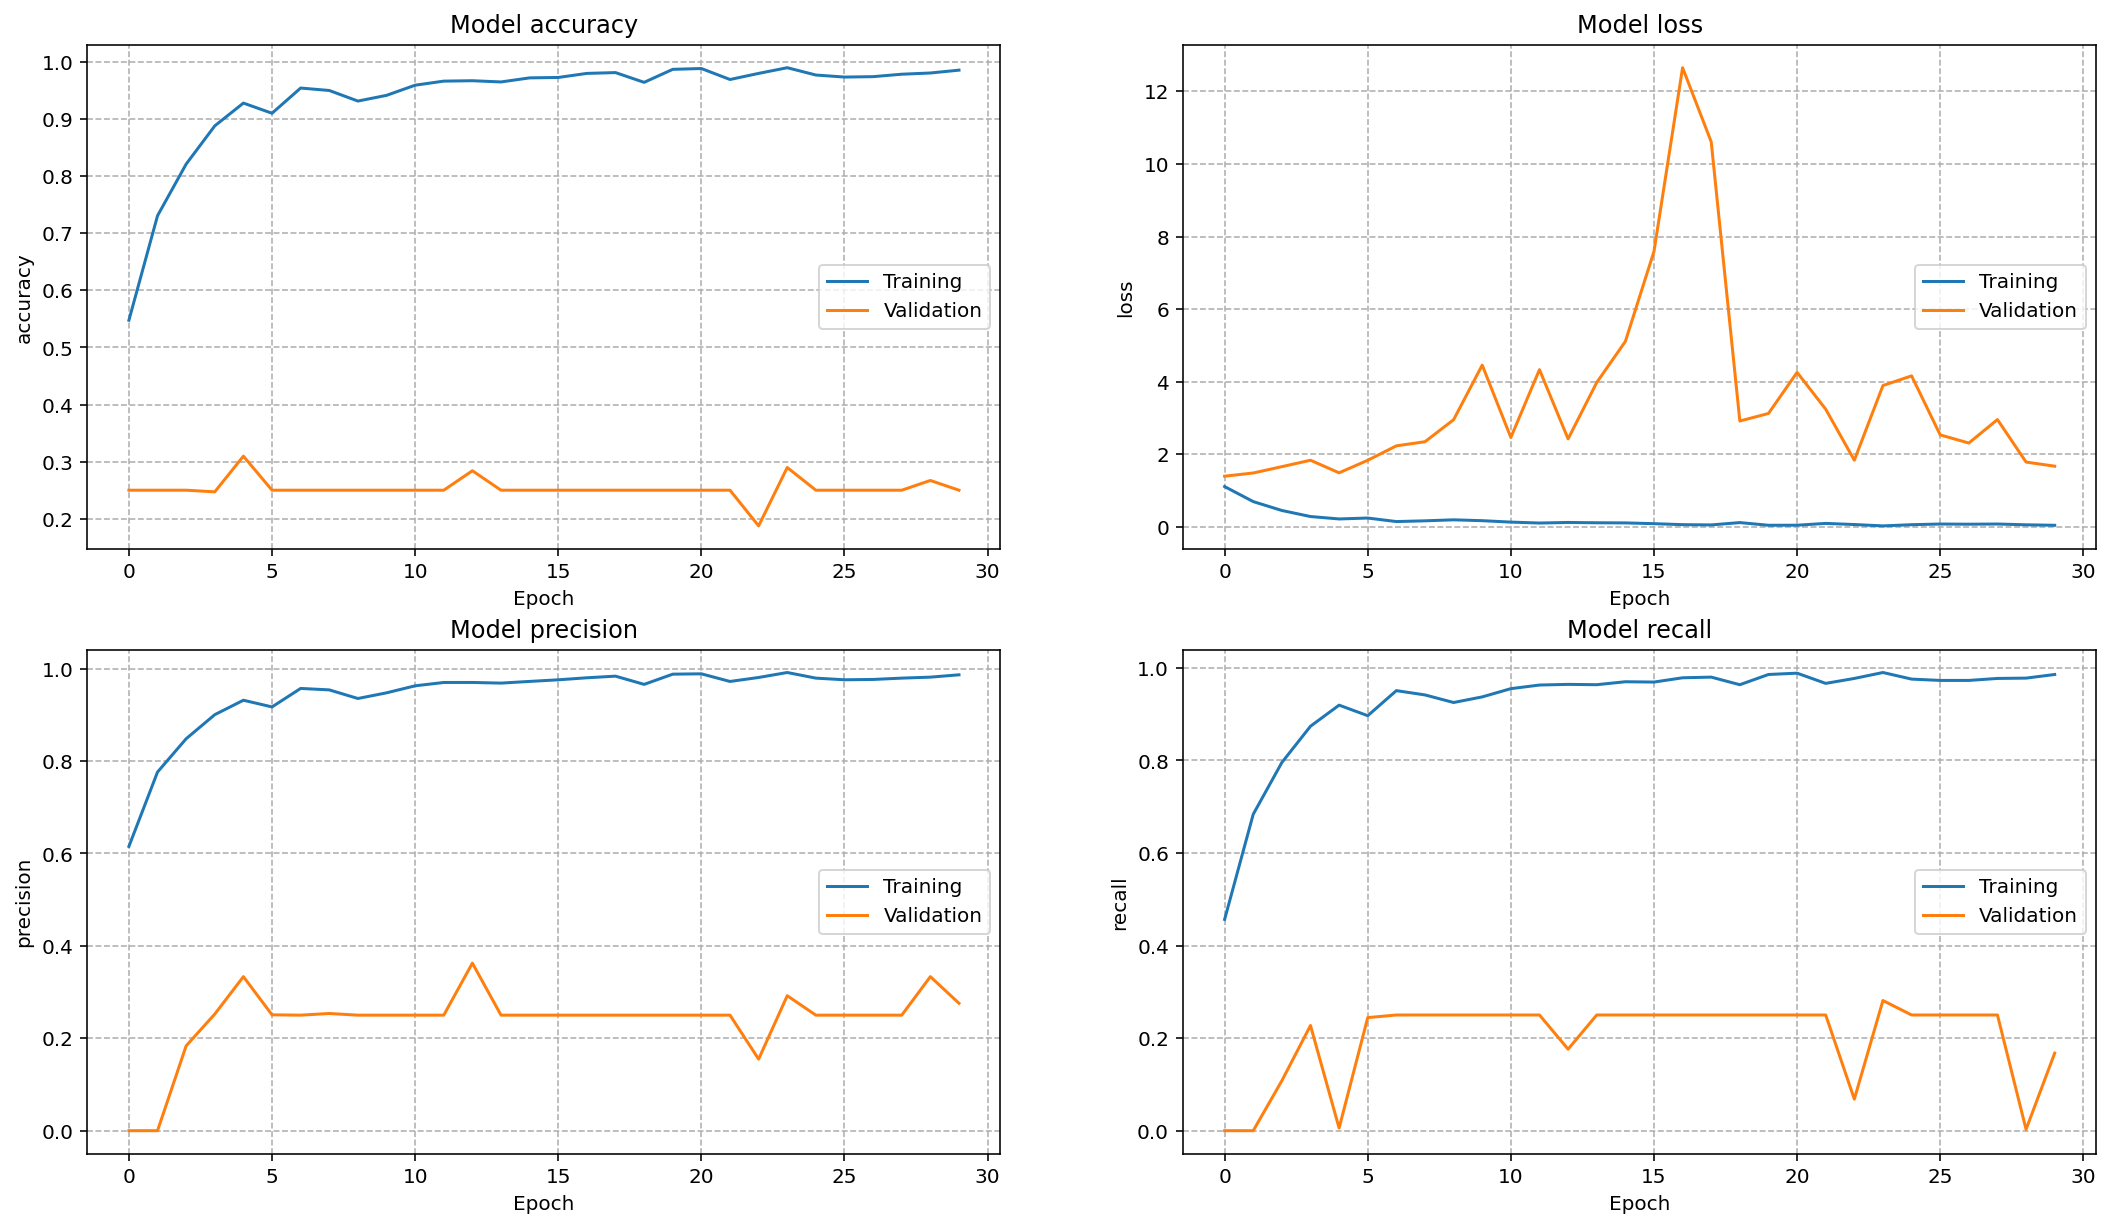

In [27]:
fig, ax = plt.subplots(2, 2, dpi=144, figsize=(18,10))
ax = ax.flatten()
for i, metric in enumerate(['accuracy', 'loss', 'precision', 'recall']):
    ax[i].plot(ef_transfer_history.history[metric], label='Training')
    ax[i].plot(ef_transfer_history.history[f'val_{metric}'], label='Validation')
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].legend(loc='center right')
    ax[i].grid(linestyle='--', ms=0.5)
plt.show()

In [28]:
ef_transfer_predicted=ef_transfer.predict(data_test/255)
ef_transfer_predicted=np.argmax(ef_transfer_predicted,axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


                    precision    recall  f1-score   support

     Mild Dementia       0.00      0.00      0.00        49
 Moderate Dementia       0.00      0.00      0.00        49
      Non Demented       0.00      0.00      0.00        49
Very mild Dementia       0.25      1.00      0.40        49

          accuracy                           0.25       196
         macro avg       0.06      0.25      0.10       196
      weighted avg       0.06      0.25      0.10       196



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


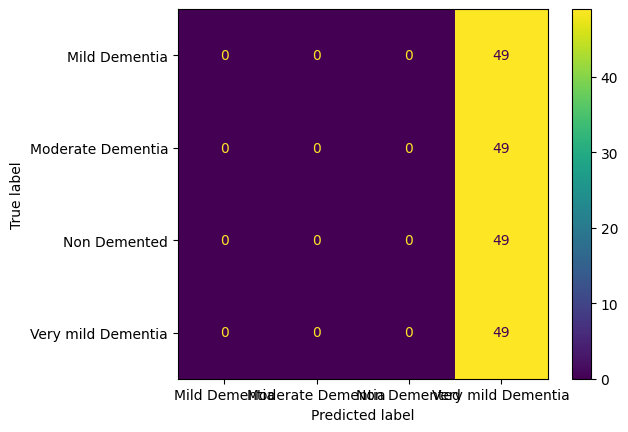

In [29]:
cm=confusion_matrix(np.argmax(label_test,axis=1),ef_transfer_predicted)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_encoder.classes_)
disp.plot()

print(classification_report(np.argmax(label_test,axis=1),ef_transfer_predicted,target_names=label_encoder.classes_))

### Custom CNN

In [43]:
def cnn_double_conv(filters):
    def apply(x):
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        return x
    return apply

In [44]:
def cnn(input_shape=(128, 128, 3)):
    inputs=layers.Input(shape=input_shape)
    cn1=cnn_double_conv(32)(inputs)
    mp1=layers.MaxPooling2D((2,2))(cn1)
    dp1=layers.Dropout(0.25)(mp1)

    cn2=cnn_double_conv(64)(dp1)
    mp2=layers.MaxPooling2D((2,2))(cn2)
    dp2=layers.Dropout(0.25)(mp2)

    cn3=cnn_double_conv(128)(dp2)
    mp3=layers.MaxPooling2D((2,2))(cn3)
    dp3=layers.Dropout(0.25)(mp3)

    x=layers.Flatten()(dp3)
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dropout(0.2)(x)

    outputs=layers.Dense(4,activation='softmax')(x)
    return models.Model(inputs, outputs)

In [45]:
custom_cnn=cnn()
custom_cnn.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,678,692 (33.11 MB)

 Trainable params: 8,677,796 (33.10 MB)

 Non-trainable params: 896 (3.50 KB)

In [46]:
model=tf.keras.Sequential([
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)),
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128,(3,3),activation='relu'),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4,activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
custom_cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','precision','recall'])

In [48]:
custom_cnn_history=custom_cnn.fit(data_train_classification_processed,epochs=30,validation_data=data_validation_classification_processed)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 363ms/step - accuracy: 0.3776 - loss: 14.9194 - precision: 0.3835 - recall: 0.3461 - val_accuracy: 0.2500 - val_loss: 5.7478 - val_precision: 0.2500 - val_recall: 0.2500
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.5981 - loss: 0.9566 - precision: 0.7733 - recall: 0.4630 - val_accuracy: 0.2500 - val_loss: 9.8045 - val_precision: 0.2500 - val_recall: 0.2500
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.7031 - loss: 0.7635 - precision: 0.7939 - recall: 0.5998 - val_accuracy: 0.2500 - val_loss: 5.4084 - val_precision: 0.2500 - val_recall: 0.2500
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7158 - loss: 0.6775 - precision: 0.8223 - recall: 0.6370 - val_accuracy: 0.2500 - val_loss: 5.3030 - val_precision: 0.2500 - val_recall: 0.2500
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.7357 - loss: 0.6441 - precision: 0.8073 - recall: 0.6565 - val_accuracy: 0.2670 - val_loss: 4.3

In [49]:
custom_cnn_predicted=custom_cnn.predict(data_test/255)
custom_cnn_predicted=np.argmax(custom_cnn_predicted,axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step


                    precision    recall  f1-score   support

     Mild Dementia       0.84      1.00      0.92        49
 Moderate Dementia       0.96      1.00      0.98        49
      Non Demented       1.00      0.80      0.89        49
Very mild Dementia       0.90      0.88      0.89        49

          accuracy                           0.92       196
         macro avg       0.93      0.92      0.92       196
      weighted avg       0.93      0.92      0.92       196



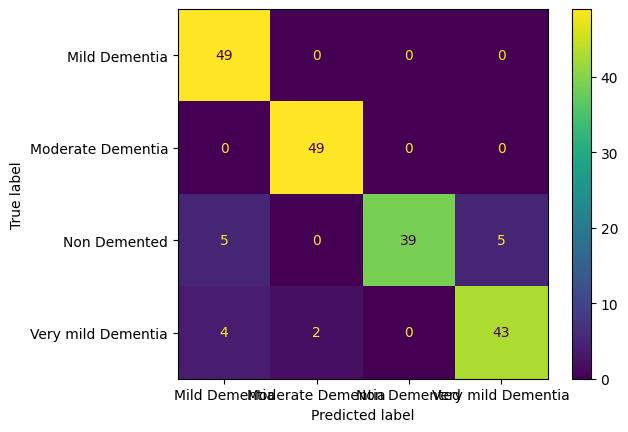

In [50]:
cm=confusion_matrix(np.argmax(label_test,axis=1),custom_cnn_predicted)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_encoder.classes_)
disp.plot()

print(classification_report(np.argmax(label_test,axis=1),custom_cnn_predicted,target_names=label_encoder.classes_))